In [311]:
import pyodbc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import BDay
from datetime import datetime
import pytz

In [312]:
import os
def GetDesktopPath():
    return os.path.join(os.path.expanduser("~"), 'Desktop')

path = GetDesktopPath()

In [313]:
scope = '2021-01'

In [314]:
cklist_confirm_query = """ 
SELECT [projectSizeId]
      ,[PROJECT_SIZE_NAME] as 'Project_Name'
      ,LEFT([typeName],4) + Right([typeName],1) as 'Phase'
      ,[status]
      ,[rejectReason]
      ,[kickOffMeetingDate]
      ,[baseOverDueDate] as 'actualCloseMeetingDate'
      ,[submitDate] as 'GMLASubmitDate'
      ,[IsByPass] 
  FROM [PR_WEB2].[dbo].[T_GMLA_CKLIST_CONFIRM]

  LEFT JOIN [PR_WEB2].[dbo].[T_PS_ProdSizeRelateInfo]
  on projectSizeId = PROJECT_SIZE_ID
  /* Join project names */

  LEFT JOIN [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE]
  ON typeId = [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE].id
  /* Join GMLA#1/#2/#3 name*/

  WHERE [IsByPass] = '0'
"""


In [315]:
project_schedule_query = """ 
SELECT [ProjectSizeId] as 'projectSizeId'
      /*
      ,[PROJECT_NAME]
      ,[T_GT_ProjectSchedule].[TASK_ID]
      */
      ,[DESC_OF_TASK]
      /*
      ,[T_GT_TaskBaseInfo].[Note]
      ,[IsPM]
      */
      ,DATEADD(DAY,-21,[Current_Date]) as 'estCloseMeetingDate'
      /* Design review -21 days */
  FROM [PR_WEB2].[dbo].[T_GT_ProjectSchedule]

  LEFT JOIN [PR_WEB2].[dbo].[T_GT_TaskBaseInfo] 
  ON [T_GT_ProjectSchedule].[TASK_ID] = [T_GT_TaskBaseInfo].TASK_ID

  LEFT JOIN [PR_WEB2].[dbo].[T_PS_ProdSizeRelateInfo]
  on ProjectSizeId = [T_PS_ProdSizeRelateInfo].PROJECT_SIZE_ID
  
  WHERE DESC_OF_TASK
  IN ('Mechanical Design Review','Factory Prototype Design Review','Pilot Run Design Review') 
"""

In [316]:
server = 'T1-PE-SUPPORT' 
database = 'PR_WEB2' 
username = 'pieng' 
password = 'Q2iT5cwHJW3FH'
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()
df = pd.read_sql(cklist_confirm_query, cnxn)
project_schedule = pd.read_sql(project_schedule_query, cnxn, parse_dates='estCloseMeetingDate')


In [317]:
df.replace('0001-01-08 00:00:00.0000000 +08:00', np.nan, inplace=True)

In [318]:
df.actualCloseMeetingDate = pd.to_datetime(df.actualCloseMeetingDate, utc=True)
df.GMLASubmitDate = pd.to_datetime(df.GMLASubmitDate,utc=True)

In [319]:
df.actualCloseMeetingDate = df.actualCloseMeetingDate.dt.tz_convert('Asia/Taipei')
df.GMLASubmitDate = df.GMLASubmitDate.dt.tz_convert('Asia/Taipei')

In [320]:
df['target_GMLASubmitDate'] = (df.actualCloseMeetingDate + BDay(9))

In [321]:
df.head()

,projectSizeId,Project_Name,Phase,status,rejectReason,kickOffMeetingDate,actualCloseMeetingDate,GMLASubmitDate,IsByPass,target_GMLASubmitDate
0,766,GAD 13,GMLA1,0,None,None,NaT,NaT,0,NaT
1,766,GAD 13,GMLA2,0,None,None,NaT,NaT,0,NaT
2,766,GAD 13,GMLA3,0,None,None,NaT,NaT,0,NaT
3,775,zumo X,GMLA1,0,None,None,NaT,NaT,0,NaT
4,775,zumo X,GMLA2,0,None,None,NaT,NaT,0,NaT


Forecast

In [322]:
project_schedule['Phase'] = project_schedule.DESC_OF_TASK.map(
    {'Mechanical Design Review':'GMLA1','Factory Prototype Design Review':'GMLA2','Pilot Run Design Review':'GMLA3'})

In [323]:
project_schedule.drop_duplicates(subset=['projectSizeId','Phase'], inplace=True)

In [324]:
project_schedule.estCloseMeetingDate = project_schedule.estCloseMeetingDate.dt.tz_convert('Asia/Taipei')

In [325]:
forecast = pd.merge(left=df, right=project_schedule, how='left', on=['projectSizeId','Phase'])

In [327]:
forecast[forecast.projectSizeId == 815]

,projectSizeId,Project_Name,Phase,status,rejectReason,kickOffMeetingDate,actualCloseMeetingDate,GMLASubmitDate,IsByPass,target_GMLASubmitDate,DESC_OF_TASK,estCloseMeetingDate
49,815,BMW MGU22/IDC,GMLA2,1,None,None,2020-12-18 00:00:00+08:00,2021-01-27 11:49:37.198915400+08:00,0,2020-12-31 00:00:00+08:00,Factory Prototype Design Review,2021-06-09 00:00:00+08:00
50,815,BMW MGU22/IDC,GMLA3,0,None,None,2022-06-30 00:00:00+08:00,NaT,0,2022-07-13 00:00:00+08:00,Pilot Run Design Review,NaT


In [328]:
forecast =forecast[['projectSizeId','Project_Name','Phase','status','actualCloseMeetingDate','estCloseMeetingDate']]

In [329]:
forecast.head()

,projectSizeId,Project_Name,Phase,status,actualCloseMeetingDate,estCloseMeetingDate
0,766,GAD 13,GMLA1,0,NaT,NaT
1,766,GAD 13,GMLA2,0,NaT,NaT
2,766,GAD 13,GMLA3,0,NaT,NaT
3,775,zumo X,GMLA1,0,NaT,2019-04-15 00:00:00+08:00
4,775,zumo X,GMLA2,0,NaT,NaT


In [330]:
def mergeCloseMeeting(actualCloseMeetingDate, estCloseMeetingDate):
    if actualCloseMeetingDate is pd.NaT:
        return estCloseMeetingDate
    else:
        return actualCloseMeetingDate

In [331]:
forecast['mergedCloseMeetingDate'] = np.vectorize(mergeCloseMeeting)(forecast.actualCloseMeetingDate, forecast.estCloseMeetingDate)

In [332]:
forecast

,projectSizeId,Project_Name,Phase,status,actualCloseMeetingDate,estCloseMeetingDate,mergedCloseMeetingDate
0,766,GAD 13,GMLA1,0,NaT,NaT,NaT
1,766,GAD 13,GMLA2,0,NaT,NaT,NaT
2,766,GAD 13,GMLA3,0,NaT,NaT,NaT
3,775,zumo X,GMLA1,0,NaT,2019-04-15 00:00:00+08:00,2019-04-15 00:00:00+08:00
4,775,zumo X,GMLA2,0,NaT,NaT,NaT
...,...,...,...,...,...,...,...
546,1126,Next gen GMR magnetron domes -GMR 24 XHD NEXT GEN,GMLA2,0,NaT,2022-10-27 00:00:00+08:00,2022-10-27 00:00:00+08:00
547,1126,Next gen GMR magnetron domes -GMR 24 XHD NEXT GEN,GMLA3,0,NaT,2023-01-24 00:00:00+08:00,2023-01-24 00:00:00+08:00
548,1127,Connect 50 transition to Taiwan Manufacturing,GMLA1,0,NaT,NaT,NaT
549,1127,Connect 50 transition to Taiwan Manufacturing,GMLA2,0,NaT,NaT,NaT


In [333]:
forecast[forecast.projectSizeId == 815]

,projectSizeId,Project_Name,Phase,status,actualCloseMeetingDate,estCloseMeetingDate,mergedCloseMeetingDate
49,815,BMW MGU22/IDC,GMLA2,1,2020-12-18 00:00:00+08:00,2021-06-09 00:00:00+08:00,2020-12-18 00:00:00+08:00
50,815,BMW MGU22/IDC,GMLA3,0,2022-06-30 00:00:00+08:00,NaT,2022-06-30 00:00:00+08:00


In [334]:
forecast['targetGMLASubmitDate'] = (forecast.mergedCloseMeetingDate + BDay(9))

In [335]:
forecast = forecast[['projectSizeId','status','Project_Name','Phase','targetGMLASubmitDate']]

In [336]:
forecast['targetGMLASubmitDate'] = forecast['targetGMLASubmitDate'].dt.date

<ipython-input-336-12858e44cdd2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast['targetGMLASubmitDate'] = forecast['targetGMLASubmitDate'].dt.date


In [337]:
forecast

,projectSizeId,status,Project_Name,Phase,targetGMLASubmitDate
0,766,0,GAD 13,GMLA1,NaT
1,766,0,GAD 13,GMLA2,NaT
2,766,0,GAD 13,GMLA3,NaT
3,775,0,zumo X,GMLA1,2019-04-26
4,775,0,zumo X,GMLA2,NaT
...,...,...,...,...,...
546,1126,0,Next gen GMR magnetron domes -GMR 24 XHD NEXT GEN,GMLA2,2022-11-09
547,1126,0,Next gen GMR magnetron domes -GMR 24 XHD NEXT GEN,GMLA3,2023-02-06
548,1127,0,Connect 50 transition to Taiwan Manufacturing,GMLA1,NaT
549,1127,0,Connect 50 transition to Taiwan Manufacturing,GMLA2,NaT


In [338]:
forecast.to_excel("forecast.xlsx")

On time

In [339]:
df.dropna(axis=0, subset=['GMLASubmitDate'], inplace=True)

In [340]:
df['on_time'] = df.target_GMLASubmitDate.dt.strftime('%Y-%m-%d') >= df.GMLASubmitDate.dt.strftime('%Y-%m-%d')

In [341]:
on_time = df.drop_duplicates(subset=['Project_Name','Phase']).sort_values(['Project_Name','Phase'])

Handle delay_but_rejected projects

In [342]:
def delay_but_rejected(on_time, rejectReason):
    if on_time == False and rejectReason != None:
        return True
    else:
        return False

In [343]:
on_time['delay_but_rejected'] = np.vectorize(delay_but_rejected)(on_time['on_time'], on_time['rejectReason'])

In [344]:
on_time = on_time[on_time.target_GMLASubmitDate> scope]

Delayed projects

In [345]:
delayed_projects = on_time[(on_time.on_time == False)].sort_values('target_GMLASubmitDate')
delayed_projects

,projectSizeId,Project_Name,Phase,status,rejectReason,kickOffMeetingDate,actualCloseMeetingDate,GMLASubmitDate,IsByPass,target_GMLASubmitDate,on_time,delay_but_rejected
175,960,fenix 7X,GMLA2,1,None,None,2020-12-30 00:00:00+08:00,2021-01-15 14:36:26.085105100+08:00,0,2021-01-12 00:00:00+08:00,False,False
19,785,DGCN20,GMLA3,1,3.C-6: please find out what's difference of CP...,None,2021-01-26 00:00:00+08:00,2021-02-22 17:34:40.150389+08:00,0,2021-02-08 00:00:00+08:00,False,True
137,936,Edge 1040,GMLA1,1,None,None,2021-02-05 00:00:00+08:00,2021-02-19 17:29:48.395736400+08:00,0,2021-02-18 00:00:00+08:00,False,False
127,909,One Battery Bike Project,GMLA3,1,Please help to modify 3.C-5 issue description.,None,2021-02-05 00:00:00+08:00,2021-03-04 15:19:42.207827800+08:00,0,2021-02-18 00:00:00+08:00,False,True
190,968,Descent G1,GMLA1,1,Strain gauge need to update the V3 PCB result ...,None,2021-03-17 00:00:00+08:00,2021-04-03 08:24:22.410314400+08:00,0,2021-03-30 00:00:00+08:00,False,True
176,960,fenix 7X,GMLA3,1,Revise 3.A-7 content (some 007- do not under 1...,2021-03-07 16:00:00.0000000 +00:00,2021-05-10 00:00:00+08:00,2021-05-24 11:20:06.622288900+08:00,0,2021-05-21 00:00:00+08:00,False,True
168,955,Varia Radar Camera (RCT715),GMLA2,1,update the mitigation plan of fail items,2021-07-04 16:00:00.0000000 +00:00,2021-08-30 00:00:00+08:00,2021-09-23 16:20:34.945172800+08:00,0,2021-09-10 00:00:00+08:00,False,True
211,979,"vivomove ""Lite""",GMLA3,1,some items are under confrimed,2021-06-30 16:00:00.0000000 +00:00,2021-09-13 00:00:00+08:00,2021-09-27 22:15:16.189070600+08:00,0,2021-09-24 00:00:00+08:00,False,True
117,895,BMW MGU22-RSE,GMLA3,1,"3.E-4, 3.E-12 項目請修正。",2021-07-19 16:00:00.0000000 +00:00,2021-09-24 00:00:00+08:00,2021-10-19 13:51:42.345835500+08:00,0,2021-10-07 00:00:00+08:00,False,True
350,1052,"GPSMAP 9000 - 22""",GMLA1,1,補充1.A-3 / 1.B-4 / 1.E-8的附件或註解,None,2021-11-25 00:00:00+08:00,2021-12-09 15:38:58.259398100+08:00,0,2021-12-08 00:00:00+08:00,False,True


In [346]:
actual_delayed_projects = on_time[(on_time.on_time == False) & (on_time.delay_but_rejected == False)].sort_values('target_GMLASubmitDate')
actual_delayed_projects

,projectSizeId,Project_Name,Phase,status,rejectReason,kickOffMeetingDate,actualCloseMeetingDate,GMLASubmitDate,IsByPass,target_GMLASubmitDate,on_time,delay_but_rejected
175,960,fenix 7X,GMLA2,1,None,None,2020-12-30 00:00:00+08:00,2021-01-15 14:36:26.085105100+08:00,0,2021-01-12 00:00:00+08:00,False,False
137,936,Edge 1040,GMLA1,1,None,None,2021-02-05 00:00:00+08:00,2021-02-19 17:29:48.395736400+08:00,0,2021-02-18 00:00:00+08:00,False,False


Resample

In [347]:
on_time_resampled = on_time.set_index('target_GMLASubmitDate').resample(rule='BM').agg({'Project_Name':'count','on_time':'sum','delay_but_rejected':'sum'})

In [348]:
on_time_resampled.rename(columns={'Project_Name':'total_projects','on_time':'on_time_projects','rejectReason':'rejcted_projects'}, inplace=True)

Convert datetime format

In [349]:
on_time_resampled.reset_index(inplace=True)

In [350]:
on_time_resampled['target_GMLASubmitDate'] = on_time_resampled['target_GMLASubmitDate'].dt.strftime('%Y-%m')

In [351]:
on_time_resampled = on_time_resampled.set_index('target_GMLASubmitDate')

In [352]:
on_time_resampled['on_time_rate'] = (100* (on_time_resampled.on_time_projects / on_time_resampled.total_projects)).round(2)

In [353]:
on_time_resampled['actual_on_time_rate'] = (100* ((on_time_resampled.on_time_projects+ on_time_resampled.delay_but_rejected) / on_time_resampled.total_projects)).round(2)

In [354]:
on_time_resampled

,total_projects,on_time_projects,delay_but_rejected,on_time_rate,actual_on_time_rate
target_GMLASubmitDate,,,,,
2021-01,9,8,0,88.89,88.89
2021-02,9,6,2,66.67,88.89
2021-03,10,9,1,90.00,100.00
2021-04,14,14,0,100.00,100.00
2021-05,10,9,1,90.00,100.00
2021-06,13,13,0,100.00,100.00
2021-07,8,8,0,100.00,100.00
2021-08,2,2,0,100.00,100.00
2021-09,9,7,2,77.78,100.00


In [355]:
#on_time_resampled.to_excel(path+'\on_time.xlsx')

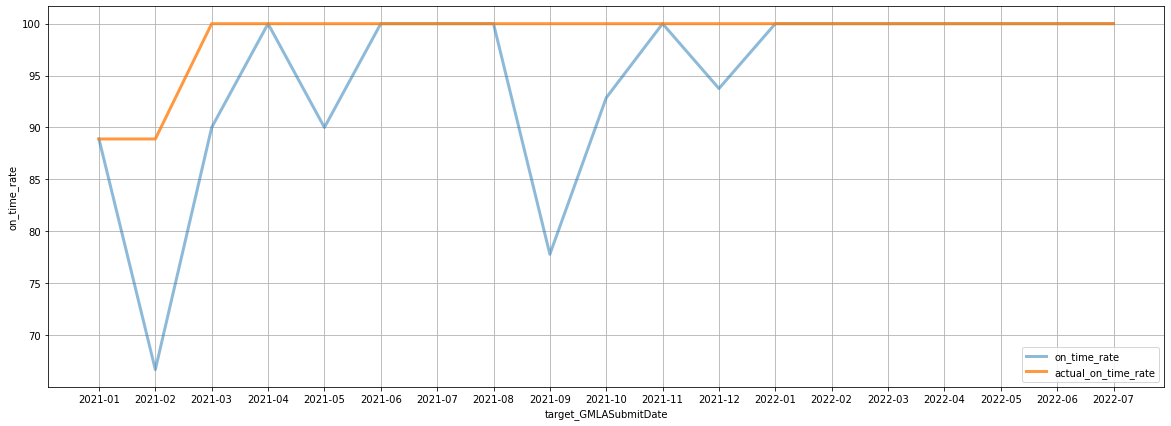

In [356]:
plt.figure(figsize=(20,7))
plt.grid()
sns.lineplot(data=on_time_resampled.on_time_rate, estimator=None, linewidth=3, alpha=0.5)
sns.lineplot(data=on_time_resampled.actual_on_time_rate, estimator=None, linewidth=3, alpha=0.8)
plt.legend(['on_time_rate','actual_on_time_rate'], loc='lower right')
plt.savefig(os.getcwd()+'\on_time_tread')